# Quantum Annealer for Phylogenetic Trees

---

In this notebook, we are going to use D-Wave's Ocean to create the needed optimization problem to reconstruct Phylogenetic Trees. In short, this is where the real work begins. This work will be based in 2 documents, a book that describes Quantum Annealing [1], and the paper for reconstruction of Phylogenetic Trees [2].



[1] Combarro, E. F., & Gonzalez-Castillo, S. (2023). A practical guide to quantum machine learning and quantum optimisation: Hands-On Approach to Modern Quantum Algorithms. Packt Publishing.

[2] Onodera, W., Hara, N., Aoki, S., Asahi, T., & Sawamura, N. (2022). Phylogenetic tree reconstruction via graph cut presented using a quantum-inspired computer. Molecular Phylogenetics and Evolution, 178, 107636. https://doi.org/10.1016/j.ympev.2022.107636

In [1]:
import numpy as np
import dimod
from dimod import BinaryQuadraticModel, BINARY
from typing import Optional
from dwave.system import DWaveSampler, EmbeddingComposite
from colorama import Fore
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import re
from qa_functions import *
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix

First, we start with an example:

In [3]:
# Coefficients of the quadratic term elements (squared or products)
J = {(0,1):1, (0,2):1}
# Coefficients of the linear terms
h = {}
problem = BinaryQuadraticModel(h, J, 0.0, BINARY)
print("The problem we are going to solve is:")
print(problem)

The problem we are going to solve is:
BinaryQuadraticModel({0: 0.0, 1: 0.0, 2: 0.0}, {(1, 0): 1.0, (2, 0): 1.0}, 0.0, 'BINARY')


From the paper we have that the minimization is defined as:

$$Min_{cut}=\sum_{i=1}^{n-1}\sum_{j=i+1}^n d_{ij}(x_i-x_j)^2,\qquad x_i=\{0,1\}, \quad i = 1,...,n.$$

Where $d_{ij}$ is the element $ij$ from the matrix $D$, where the differences between elements are represented. In other words, if you consider the problem as a graph, $D$ is the adjacency matrix from the graph.

If we take a closer look at this formula, we can see that we take the top part of the matrix, also, we start counting from 1, and I don't want that, so we can rewrite the expression as:

$$Min_{cut}=\sum_{i=0}^{n-2}\sum_{j=i+1}^{n-1} d_{ij}(x_i-x_j)^2,\qquad x_i=\{0,1\}, \quad i = 0,...,n-1.$$

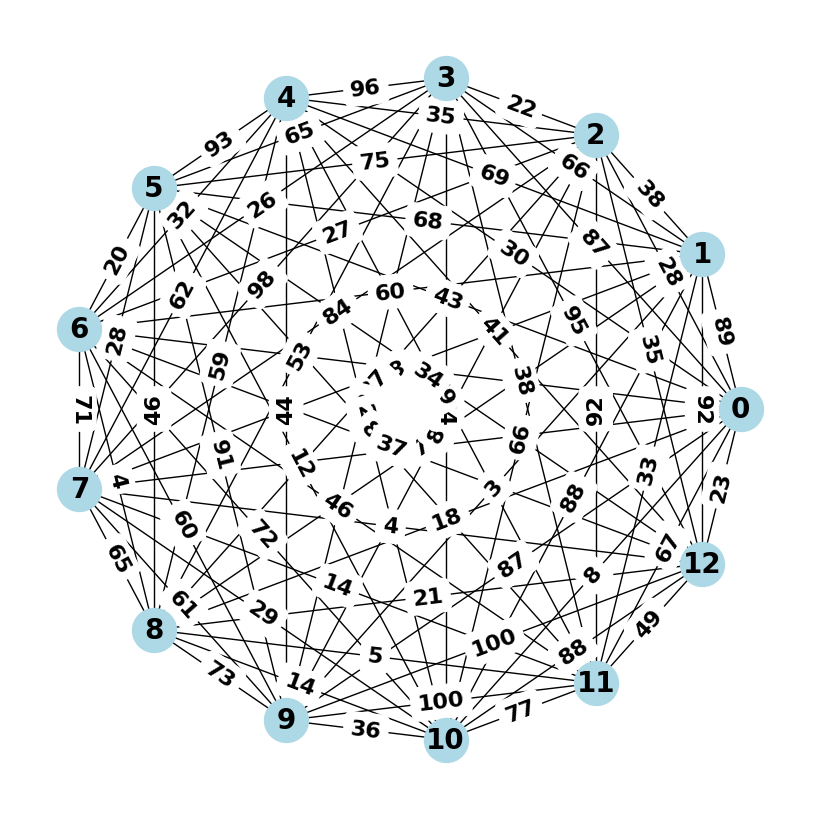

In [87]:
# Create a complete graph with n nodes
G = nx.complete_graph(13)

# Assign random weights normalized between 0 and 100
for u, v in G.edges():
    G[u][v]['weight'] = random.randint(0, 100)

# Positions for a circular layout
pos = nx.circular_layout(G)

# Draw the graph
plt.figure(figsize=(8, 8))
nx.draw(
    G, pos, with_labels=True, node_color='lightblue', 
    node_size=1000, font_size=20, font_weight='bold'
)

# Draw edge labels with weights
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=edge_labels, font_color='black', font_size=16, font_weight='bold'
)

plt.show()

To start, as I don't have any data to create adjacency matrices, I can create a random all-to-all graph with the characteristics defined in the paper. The graph would be the next:

<div style="text-align: center;">
    <img src="./images/randgraph_5.png" alt="Complete Graph" width="600px">
</div>

Defined by the following adjacency matrix:

$$
\begin{pmatrix}
    0  & 92 & 73 & 78 & 92 \\
    92 & 0  & 21 & 49 & 34 \\
    73 & 21 & 0  & 35 & 63 \\
    78 & 49 & 35 & 0  & 29 \\
    92 & 34 & 63 & 29 & 0 \\
\end{pmatrix}
$$

Firstly, we can create a function that creates ``BinaryQuadraticModel`` objects from a given matrix for our problem. This will facilitate the process hereafter.

In [20]:
# Function to create BinaryQuadraticModel from a numpy matrix
def create_problem (matrix:np.ndarray)->BinaryQuadraticModel:
    r"""
    Creates a BinaryQuadraticModel from a numpy matrix using the Min-cut formulation. Both simmetrical matrices and matrices with 0 above the main diagonal work.
    
    Args:
        `matrix`: Matrix that defines the problem.
    
    Returns:
        The BinaryQuadraticModel from dimod that defines the problem.
    """
    
    rows = matrix.shape[0]
    var = []
    
    for i in range(rows):
        var.append(dimod.Binary('x'+str(i)))
        
    obj = BinaryQuadraticModel({},{},0.0,BINARY)
    
    for i in range(rows):
        for j in range(i):
            obj+=matrix[i,j]*(var[i]-var[j])**2
            
    return obj

In [5]:
matrix = np.array( [[ 0, 92, 73, 78, 92],
                    [92,  0, 21, 49, 34],
                    [73, 21,  0, 35, 63],
                    [78, 49, 35,  0, 29],
                    [92, 34, 63, 29,  0]])

problem = create_cqm_problem(matrix,c=1,alpha=5*100)
print(problem)

Constrained quadratic model: 5 variables, 0 constraints, 15 biases

Objective
  500 - 304*Binary(1) - 165*Binary(0) - 308*Binary(2) - 309*Binary(3) - 282*Binary(4) + 816*Binary(1)*Binary(0) + 958*Binary(1)*Binary(2) + 854*Binary(0)*Binary(2) + 902*Binary(1)*Binary(3) + 844*Binary(0)*Binary(3) + 930*Binary(2)*Binary(3) + 932*Binary(1)*Binary(4) + 816*Binary(0)*Binary(4) + 874*Binary(2)*Binary(4) + 942*Binary(3)*Binary(4)

Constraints

Bounds



It's important to know that the next cell access the D-Wave Quantum Annealer. That's why there's commented lines.

In [ ]:
# You need to have an access token configured
# sampler = EmbeddingComposite(DWaveSampler())
# result = sampler.sample(problem, num_reads=10)
print("The solutions that we have obtained are")
print(result)

The solutions that we have obtained are
   0  1  2  3  4 energy num_oc. chain_.
0  0  0  0  0  0    0.0       5     0.0
1  1  1  1  1  1    0.0       5     0.0
['BINARY', 2 rows, 10 samples, 5 variables]


In [55]:
print(f'Time required to complete: {result.info['timing']['qpu_access_time']}ms')

Time required to complete: 16541.56ms


In [45]:
x0 = dimod.Binary('x0')
x1 = dimod.Binary('x1')
x2 = dimod.Binary('x2')

blp = dimod.ConstrainedQuadraticModel()

blp.set_objective(3*(x0-x1)**2+3*(x1-x2)**2+(x0-x2)**2+24*(x0+x1+x2-1)**2)
# blp.add_constraint(x0+x1+x2 == 1 )
# blp.add_constraint(x0+x1+x2 <= 2 )

print(blp)

solver = dimod.ExactCQMSolver()

sol = solver.sample_cqm(blp)

print('Solutions')
print(sol,'\n')

# We want the best feasible solution. We can filter by its feasibility and take the first element
feas_sol = sol.filter(lambda s: s.is_feasible)
print(Fore.RED+'Best Solution'+Fore.RESET)
print(f'Variables: {feas_sol.first.sample}, Cost = {feas_sol.first.energy}')

Constrained quadratic model: 3 variables, 0 constraints, 6 biases

Objective
  24 - 20*Binary('x0') - 18*Binary('x1') - 20*Binary('x2') + 42*Binary('x0')*Binary('x1') + 46*Binary('x0')*Binary('x2') + 42*Binary('x1')*Binary('x2')

Constraints

Bounds

Solutions
  x0 x1 x2 energy num_oc. is_sat. is_fea.
2  1  0  0    4.0       1 arra... np.T...
4  0  0  1    4.0       1 arra... np.T...
1  0  1  0    6.0       1 arra... np.T...
0  0  0  0   24.0       1 arra... np.T...
3  1  1  0   28.0       1 arra... np.T...
5  0  1  1   28.0       1 arra... np.T...
6  1  0  1   30.0       1 arra... np.T...
7  1  1  1   96.0       1 arra... np.T...
['INTEGER', 8 rows, 8 samples, 3 variables] 

Best Solution
Variables: {'x0': np.int64(1), 'x1': np.int64(0), 'x2': np.int64(0)}, Cost = 4.0


In [144]:
qubo = dimod.cqm_to_bqm(blp,lagrange_multiplier=5)
print(qubo)

(BinaryQuadraticModel({'x0': 3.0, 'x1': 5.0, 'x2': 3.0}, {('x1', 'x0'): -4.0, ('x2', 'x0'): 0.0, ('x2', 'x1'): -4.0}, 1.0, 'BINARY'), <dimod.constrained.constrained.CQMToBQMInverter object at 0x000002089A377640>)


In [2]:
# Function to create BinaryQuadraticModel from a numpy matrix
def create_cqm_problem (matrix:np.ndarray,tags=[],c=0,alpha=0)->dimod.ConstrainedQuadraticModel:
    r"""
    Creates a ConstrainedQuadraticModel from a numpy matrix using the Min-cut formulation. Both simmetrical matrices and matrices with 0 above the main diagonal work.
    
    Args:
        `matrix`: Matrix that defines the problem.
        `tags`: Name for the variables. Used in the Philogenetic Tree to mantain tags for each matrix.
        `c`: Number of non zero results wanted.
        `alpha`: Factor to amplify. Higher alpha (>1) achieve the number of `c` of non zero results easily. If 0, no defined `c` is set, thus 11...11 and 00...00 become the best solution.
    
    Returns:
        The ConstrainedQuadraticModel from dimod that defines the problem.
    """
    
    rows = matrix.shape[0]
    var = []
    
    if not tags:
        for i in range(rows):
            var.append(dimod.Binary(i))
    else:
        var = [dimod.Binary(i) for i in tags]
        
    obj = BinaryQuadraticModel({},{},0.0,BINARY)
    
    for i in range(rows):
        for j in range(i):
            obj+=matrix[i,j]*(var[i]-var[j])**2
    
    suma = np.sum(var)      
    # Add restriction term
    obj+=alpha*(suma-c)**2
    
    problem = dimod.ConstrainedQuadraticModel()
    
    problem.set_objective(obj)
    
    return problem

In [28]:
matrix = np.array([[0,0,0,0,0],[92,0,0,0,0],[73,21,0,0,0],[78,49,35,0,0],[92,34,63,29,0]])

problem = create_cqm_problem(matrix,c=2,alpha=100)

sol = solver.sample_cqm(problem)

print(problem)

print('Solutions')
print(sol,'\n')

# We want the best feasible solution. We can filter by its feasibility and take the first element
feas_sol = sol.filter(lambda s: s.is_feasible)
print(Fore.RED+'Best Solution'+Fore.RESET)
print(f'Variables: {feas_sol.first.sample}, Cost = {feas_sol.first.energy}')

NameError: name 'solver' is not defined

In [40]:
qprob = dimod.cqm_to_bqm(problem)

print(qprob)

(BinaryQuadraticModel({'x1': 196.0, 'x0': 335.0, 'x2': 192.0, 'x3': 191.0, 'x4': 218.0}, {('x0', 'x1'): -184.0, ('x2', 'x1'): -42.0, ('x2', 'x0'): -146.0, ('x3', 'x1'): -98.0, ('x3', 'x0'): -156.0, ('x3', 'x2'): -70.0, ('x4', 'x1'): -68.0, ('x4', 'x0'): -184.0, ('x4', 'x2'): -126.0, ('x4', 'x3'): -58.0}, 0.0, 'BINARY'), <dimod.constrained.constrained.CQMToBQMInverter object at 0x00000233FF201570>)


After this tests, we see that with a high enough $\alpha$ we can guarantee that the best solution contais the subdivision that we want. Knowing this, with good management of the variables we can achieve a solution without adding consraints. Thus, we will refrain from using constraints and use directly the `BinaryQuadraticModel`. However, we will mantain the function `create_cqm_problem` for future convenience of obtaining all solutions in a simple way.

In the next cell, there will be the final problem creation function, so **refrain from using the function from cell 8**.

In [3]:
def min_cut_c (matrix:np.ndarray,tags=[],c=0,alpha=0)->BinaryQuadraticModel:
    r"""
    Creates a BinaryQuadraticModel from a numpy matrix using the Min-cut formulation. Both simmetrical matrices and matrices with 0 above the main diagonal work.
    
    Args:
        `matrix`: Matrix that defines the problem.
        `c`: Number of non zero results desired.
        `alpha`: Factor to amplify. Higher alpha (>1) achieve the number of `c` of non zero results easily. If 0, no defined `c` is set, thus 11...11 and 00...00 become the best solution.
    
    Returns:
        The BinaryQuadraticModel from dimod that defines the problem.
    """
    
    rows = matrix.shape[0]
    var = []
    
    if not tags:
        for i in range(rows):
            var.append(dimod.Binary(i))
    else:
        var = [dimod.Binary(i) for i in tags]
    obj = BinaryQuadraticModel({},{},0.0,BINARY)
    
    for i in range(rows):
        for j in range(i):
            obj+=matrix[i,j]*(var[i]-var[j])**2
    
    suma = np.sum(var)      
    # Add restriction term
    obj+=alpha*(suma-c)**2
    
    return obj

In [ ]:
# Test the code using D-Wave QA
matrix = np.array([[0,0,0,0,0],[92,0,0,0,0],[73,21,0,0,0],[78,49,35,0,0],[92,34,63,29,0]])

problem = min_cut_c(matrix,c=2,alpha=200)

print(problem)

sampler = EmbeddingComposite(DWaveSampler())
result = sampler.sample(problem, num_reads=10)
print("The solutions that we have obtained are")
print(result)

BinaryQuadraticModel({'x3': -404.0, 'x4': -265.0, 'x2': -408.0, 'x1': -409.0, 'x0': -382.0}, {('x4', 'x3'): 216.0, ('x2', 'x3'): 358.0, ('x2', 'x4'): 254.0, ('x1', 'x3'): 302.0, ('x1', 'x4'): 244.0, ('x1', 'x2'): 330.0, ('x0', 'x3'): 332.0, ('x0', 'x4'): 216.0, ('x0', 'x2'): 274.0, ('x0', 'x1'): 342.0}, 800.0, 'BINARY')
The solutions that we have obtained are
  x0 x1 x2 x3 x4 energy num_oc. chain_.
0  1  0  1  0  0  284.0       4     0.0
1  0  1  0  1  0  289.0       3     0.0
2  0  1  1  0  0  313.0       1     0.0
3  0  0  0  1  1  347.0       1     0.0
4  1  1  0  0  0  351.0       1     0.0
['BINARY', 5 rows, 10 samples, 5 variables]


In [24]:
print(f'Time required to complete: {result.info['timing']['qpu_access_time']}us')
print(f'Best solution energy: {result.first.energy}')
print(f'Best solution configuration: {result.first.sample}')

n_graph_0 = [i for i in result.first.sample if result.first.sample[i]==0]
n_graph_1 = [i for i in result.first.sample if result.first.sample[i]==1]

print(f'The cut graph are:\nGraph 1: {n_graph_0}\nGraph 2: {n_graph_1}')

Time required to complete: 16765.56us
Best solution energy: 284.0
Best solution configuration: {'x0': np.int8(1), 'x1': np.int8(0), 'x2': np.int8(1), 'x3': np.int8(0), 'x4': np.int8(0)}
The cut graph are:
Graph 1: ['x1', 'x3', 'x4']
Graph 2: ['x0', 'x2']


In [34]:
indices = [int(i[1]) for i in n_graph_0]
indices2 = [int(i[1]) for i in n_graph_1]

new_matrix = matrix[np.ix_(indices, indices)]

print(new_matrix)


[[ 0  0  0]
 [49  0  0]
 [34 29  0]]


In [4]:
def n_cut(score,ng0,ng1,og):
    r"""
    Returns the Ncut from a cut.
    
    Args:
        `score`: The energy level obtained from the Mincut method.
        `ng0`: The nodes defining one of the new graphs.
        `ng1`: The nodes defining the other new graph.
        `og`: The original matrix.
    Returns:
        Ncut energy level.
    """
    asoc0 = np.sum(og[ng0, :])
    asoc1 = np.sum(og[ng1, :])   
    
    # print(f'asoc0= {asoc0}, asoc1 = {asoc1}') 
    
    if asoc0 <10e-8 or asoc1 <10e-8:
        ncut = np.inf
    else:
        ncut = (score/asoc0) + (score/asoc1)
    
    return ncut

In [35]:
n_cut(result.first.energy,indices,indices2,matrix)

np.float64(3.6229715109989185)

After this, we can define the full algorithm, without the initial matrix definition.

In [54]:
# Class to create a tree
class TreeNode:
    def __init__(self, value):
        self.value = value
        self.children = []  # A list of child selfs
    
    def print_tree(self, prefix="", is_last=True):
        """
        Prints the tree structure with a visually appealing layout.

        Args:
            node (TreeNode): The current node to print.
            prefix (str): The prefix for the current node (e.g., spaces and vertical bars).
            is_last (bool): True if the node is the last child of its parent.
        """
        if self is None:
            return

        # Prettier connectors
        connector = "└── " if is_last else "├── "
        if len(self.value)!=1:
            print(prefix + connector + '|')
        else:
            print(prefix + connector + str(self.value))

        # Update the prefix for child nodes
        if self.children:
            for i, child in enumerate(self.children):
                # Use "│   " for intermediate children, "    " for the last child
                next_prefix = prefix + ("    " if is_last else "│   ")
                child.print_tree(prefix=next_prefix, is_last=(i == len(self.children) - 1))
    
    def _newick_tree(self,exp=[""]):
        """
        Prints the tree structure with a visually appealing layout.

        Args:
            node (TreeNode): The current node to print.
            is_last (bool): True if the node is the last child of its parent.
        """
        if self is None:
            return
        
        # Update the prefix for child nodes
        if self.children:
            exp[0]+='('
            for child in self.children:             
                child._newick_tree(exp)  
            exp[0]+='),'
        else:
            exp[0]+=str(self.value)[1:-1]+','
            
    def to_newick(self):
        exp = [""]
        self._newick_tree(exp)
        exp = re.sub(r",\s*\)", ")",exp[0])
        exp = re.sub(r",$", ";",exp)
        return exp
            
    def create_newick_file(self,file_name:str='tree'):
        """
        Creates a newick file from the chosen tree
        
        Args:
            tree (TreeNode): The full tree
            file_name (str): The name of the file to be written without extension
        """
        exp = [""]
        self._newick_tree(exp)
        exp = re.sub(r",\s*\)", ")",exp[0])
        exp = re.sub(r",$", ";",exp)
        with open(file_name+'.nwk','w+') as file:
            file.write(exp)
            
    # More visual way
    # Recursive function to calculate positions for nodes
    def _calculate_positions(self, x=0, y=0, dx=1,dy=0.5, positions=None, parent_positions=None, parent=None):
        if positions is None:
            positions = {}
        if parent_positions is None:
            parent_positions = []

        # Assign a position to the current node
        node_label = str(self.value)  # Convert list to string for display
        positions[node_label] = (x, y)
        if parent is not None:
            parent_positions.append((parent, node_label))

        # Layout children
        num_children = len(self.children)
        if num_children > 0:
            child_dx = dx / num_children
            child_x = x - dx / 2 + child_dx / 2
            for child in self.children:
                self.calculate_positions(child, child_x, y - dy, child_dx, dy, positions, parent_positions, node_label)
                child_x += child_dx

        return positions, parent_positions

    def _display(self,positions,parent_positions,tree_size=1,square=True,names=[]):
        plt.figure(figsize=(10*tree_size, 5*tree_size))
        
        if not square:
            for parent, child in parent_positions:
                x1, y1 = positions[parent]
                x2, y2 = positions[child]
                plt.plot([x1, x2], [y1, y2], "k-")  # Draw edges
        
        if square:
        # Draw edges with straight lines
            for parent, child in parent_positions:
                x1, y1 = positions[parent]
                x2, y2 = positions[child]

                # Horizontal line to connect parent to the child's vertical position
                plt.plot([x1, x2], [y1, y1], "k-")
                # Vertical line to connect child's position to the horizontal line
                plt.plot([x2, x2], [y1, y2], "k-")
        
        positions = {key: value for key, value in positions.items() if len(eval(key)) == 1}
        # Display nodes with single-element values
        for node, (x, y) in positions.items():
            
            if len(eval(node)) == 1:  # Check the list length
                plt.scatter(x, y, s=500, color="lightblue",edgecolors='black')
                if len(names)!= len(positions):
                    if len(node) == 4:
                        plt.text(x, y, node[1:-1], ha="center", weight='bold', va="center", fontsize=10, bbox=dict(facecolor="lightblue", edgecolor="none",boxstyle='circle,pad=0.3'))
                    else:
                        plt.text(x, y, node[1:-1], ha="center", weight='bold', va="center", fontsize=10, bbox=dict(facecolor="lightblue", edgecolor="none",boxstyle='circle,pad=0.5'))
                else:
                    if len(node) == 4:
                        plt.text(x, y, names[int(node[1:-1])], ha="center", weight='bold', va="center", fontsize=10, bbox=dict(facecolor="lightblue", edgecolor="none",boxstyle='circle,pad=0.3'))
                    else:
                        plt.text(x, y, names[int(node[1:-1])], ha="center", weight='bold', va="center", fontsize=10, bbox=dict(facecolor="lightblue", edgecolor="none",boxstyle='circle,pad=0.5'))
                    

        plt.axis("off")
        plt.title("Phylogenetic tree")
        plt.show()  
        
    def display_tree(self,tree_size=1,square=True,names=[]):
        """"Displays the tree as a graph. Encapsulates 2 functions to easily handle the fancy display.
        
        Args:
            `tree_size` (int): Factor of the renderization size (not aspect ratio)
            `square` (bool): Horizontal and vertical lines (True) or diagonal lines (False)
            `names` (list of str): Names of the nodes       
        """
        pos, par_pos = self._calculate_positions()
        self._display(pos, par_pos,tree_size=tree_size,square=square,names=names)
        
        
                

class Timer:
    def __init__(self,value=0.0) -> None:
        self.value = value
    
    def __str__(self) -> str:
        return f"{self.value}"
    
    def update(self,value):
        self.value += value

In [55]:
def phylo_tree(matrix:np.ndarray,tags=[],**kwargs):
    r"""
    Recursive function that uses D-Wave QA to create the tree using Ncut
    
    Args:
        `matrix`: The matrix defining the graph.
        `tags`: Tags defining the names of the selfs, used for recursivity, but you can also name the original 5 nodes. **MUST BE AN INT**
        Probably you could define alpha from outside.
    """
    
    
    ncuts = []
    n_graph_0 = []
    n_graph_1 = []
    sampler = EmbeddingComposite(DWaveSampler())
    
    if not tags:
        sub_mat = matrix
    else:
        sub_mat = matrix[np.ix_(tags, tags)]
        
    rows = sub_mat.shape[0]
    
    alpha = rows*100
    
    var = int(np.floor(rows/2.0))+1

    # Run min_cut for each configuration
    for i in range(1,var):
        # print(f'Corte con {i}')
        if not tags:
            problem = min_cut_c(sub_mat,c=i,alpha=alpha)
        else:
            problem = min_cut_c(sub_mat,tags=tags,c=i,alpha=alpha)
        result = sampler.sample(problem, num_reads=32)
        
        # Time measurement
        if 'timer' in kwargs:
            kwargs['timer'].update(result.info['timing']['qpu_access_time']/1000)
            
        n_graph_0.append([j for j in result.first.sample if result.first.sample[j]==0])
        n_graph_1.append([j for j in result.first.sample if result.first.sample[j]==1])        
        # print(f'\tLa division es: {n_graph_0[i-1]} | {n_graph_1[i-1]}')
        
        if not n_graph_0[i-1] or not n_graph_1[i-1]:
            n_graph_0.pop()
            n_graph_1.pop()
        else:
            ncuts.append(n_cut(result.first.energy,n_graph_0[i-1],n_graph_1[i-1],matrix))
        
    
    # Get the cuts created by the minimum ncut value
    index = np.argmin(ncuts)
    # print(f'Se selecciona la separacion: {n_graph_0[index]} | {n_graph_1[index]}')
    
    node = TreeNode(tags)
    
    # Recursivity in the first graph
    if len(n_graph_0[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(phylo_tree(matrix,n_graph_0[index],timer=kwargs['timer']))
        else:
            node.children.append(phylo_tree(matrix,n_graph_0[index]))
    else:
        leaf = TreeNode(n_graph_0[index])
        if len(n_graph_0[index]) == 2:
            leaf.children.append(TreeNode([n_graph_0[index][0]]))
            leaf.children.append(TreeNode([n_graph_0[index][1]]))
        node.children.append(leaf)
        
    # Recursivity in the first graph
    if len(n_graph_1[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(phylo_tree(matrix,n_graph_1[index],timer=kwargs['timer']))
        else:
            node.children.append(phylo_tree(matrix,n_graph_1[index]))
    else:
        leaf = TreeNode(n_graph_1[index])
        if len(n_graph_1[index]) == 2:
            leaf.children.append(TreeNode([n_graph_1[index][0]]))
            leaf.children.append(TreeNode([n_graph_1[index][1]]))
        node.children.append(leaf)
    
    return node

In [ ]:
matrix = np.array([[0,0,0,0,0],[92,0,0,0,0],[73,21,0,0,0],[78,49,35,0,0],[92,34,63,29,0]])
tree = phylo_tree(matrix)
print('El arbol resultante es: \n\n')
tree.print_tree()

El arbol resultante es: 


└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── [0]
    │   │   │   └── [4]
    │   │   └── [2]
    │   └── [1]
    └── [3]


TypeError: unhashable type: 'list'

We have created a tree. However, this tree always takes the cut with one value. To see if this is a norm or an exception, We can try other graphs, for example:

<div style="text-align: center;">
    <img src="./images/randgraph_7.png" alt="Complete Graph" width="600px">
</div>

In [ ]:
timer = Timer(0.0)
tree = phylo_tree(matrix,timer=timer)
print('The resulting tree is: \n\n')
tree.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')

The resulting tree is: 


└── |
    ├── |
    │   ├── |
    │   │   ├── [4]
    │   │   └── [6]
    │   └── |
    │       ├── [2]
    │       └── [3]
    └── |
        ├── |
        │   ├── [1]
        │   └── [5]
        └── [0]
The time used to compute the solutions is: 50.491879999999995ms


In [2]:
# Matrix to text, because of the randomness. This is the Matrix that defines the graph from './images/randgraph_7.png'
matrix = np.array([[ 0., 30., 17., 73., 33., 51.,  9.],
       [30.,  0., 32., 99., 63., 99., 48.],
       [17., 32.,  0., 80., 23.,  4.,  5.],
       [73., 99., 80.,  0., 89., 13., 95.],
       [33., 63., 23., 89.,  0., 68., 86.],
       [51., 99.,  4., 13., 68.,  0., 15.],
       [ 9., 48.,  5., 95., 86., 15.,  0.]])

It was a fluke, the program creates well distributed graphs. But, are they correct? To test this, we will make use of our function that creates a Mincut problem as a CQM and use a brute force solver. We will input this in the Ncut method to obtain the tree.

In [7]:
def bf_tree(matrix,tags=[],**kwargs):
    
    ncuts = []
    n_graph_0 = []
    n_graph_1 = []
    solver = dimod.ExactCQMSolver()
    
    if not tags:
        sub_mat = matrix
    else:
        sub_mat = matrix[np.ix_(tags, tags)]
        
    rows = sub_mat.shape[0]
    
    var = int(np.floor(rows/2.0))+1

    # Run min_cut for each configuration
    for i in range(1,var):
        # print(f'Corte con {i}')
        if 'timer' in kwargs:
            start = time.time_ns()/1000000
            
        if not tags:
            problem = create_cqm_problem(sub_mat,c=i,alpha=500)
        else:
            problem = create_cqm_problem(sub_mat,tags=tags,c=i,alpha=500)

        sol = solver.sample_cqm(problem)

        # We want the best feasible solution. We can filter by its feasibility and take the first element
        feas_sol = sol.filter(lambda s: s.is_feasible)
        
        if 'timer' in kwargs:
            end = time.time_ns()/1000000
            kwargs['timer'].update(end-start)
            
        n_graph_0.append([j for j in feas_sol.first.sample if feas_sol.first.sample[j]==0])
        n_graph_1.append([j for j in feas_sol.first.sample if feas_sol.first.sample[j]==1])   
        # print(f'\tLa division es: {n_graph_0[i-1]} | {n_graph_1[i-1]}')
        
        if not n_graph_0[i-1] or not n_graph_1[i-1]:
            n_graph_0.pop()
            n_graph_1.pop()
        else:
            ncuts.append(n_cut(feas_sol.first.energy,n_graph_0[i-1],n_graph_1[i-1],matrix))
    
    index = np.argmin(ncuts)
    # print(f'Se selecciona la separacion: {n_graph_0[index]} | {n_graph_1[index]}')
    
    node = TreeNode(tags)
    
    # Recursivity in the first graph
    if len(n_graph_0[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(bf_tree(matrix,n_graph_0[index],timer=kwargs['timer']))
        else:
            node.children.append(bf_tree(matrix,n_graph_0[index]))
    else:
        leaf = TreeNode(n_graph_0[index])
        if len(n_graph_0[index]) == 2:
            leaf.children.append(TreeNode([n_graph_0[index][0]]))
            leaf.children.append(TreeNode([n_graph_0[index][1]]))
        node.children.append(leaf)
        
    # Recursivity in the first graph
    if len(n_graph_1[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(bf_tree(matrix,n_graph_1[index],timer=kwargs['timer']))
        else:
            node.children.append(bf_tree(matrix,n_graph_1[index]))
    else:
        leaf = TreeNode(n_graph_1[index])
        if len(n_graph_1[index]) == 2:
            leaf.children.append(TreeNode([n_graph_1[index][0]]))
            leaf.children.append(TreeNode([n_graph_1[index][1]]))
        node.children.append(leaf)
    
    return node

In [8]:
# More visual way
# Recursive function to calculate positions for nodes
def calculate_positions(node, x=0, y=0, dx=1,dy=0.5, positions=None, parent_positions=None, parent=None):
    if positions is None:
        positions = {}
    if parent_positions is None:
        parent_positions = []

    # Assign a position to the current node
    node_label = str(node.value)  # Convert list to string for display
    positions[node_label] = (x, y)
    if parent is not None:
        parent_positions.append((parent, node_label))

    # Layout children
    num_children = len(node.children)
    if num_children > 0:
        child_dx = dx / num_children
        child_x = x - dx / 2 + child_dx / 2
        for child in node.children:
            calculate_positions(child, child_x, y - dy, child_dx, dy, positions, parent_positions, node_label)
            child_x += child_dx

    return positions, parent_positions

def display_tree(positions,parent_positions,tree_size=1,square=True,names=[]):
    plt.figure(figsize=(10*tree_size, 5*tree_size))
    
    if not square:
        for parent, child in parent_positions:
            x1, y1 = positions[parent]
            x2, y2 = positions[child]
            plt.plot([x1, x2], [y1, y2], "k-")  # Draw edges
    
    if square:
    # Draw edges with straight lines
        for parent, child in parent_positions:
            x1, y1 = positions[parent]
            x2, y2 = positions[child]

            # Horizontal line to connect parent to the child's vertical position
            plt.plot([x1, x2], [y1, y1], "k-")
            # Vertical line to connect child's position to the horizontal line
            plt.plot([x2, x2], [y1, y2], "k-")
    
    positions = {key: value for key, value in positions.items() if len(eval(key)) == 1}
    # Display nodes with single-element values
    for node, (x, y) in positions.items():
        
        if len(eval(node)) == 1:  # Check the list length
            plt.scatter(x, y, s=500, color="lightblue",edgecolors='black')
            if len(names)!= len(positions):
                if len(node) == 4:
                    plt.text(x, y, node[1:-1], ha="center", weight='bold', va="center", fontsize=10, bbox=dict(facecolor="lightblue", edgecolor="none",boxstyle='circle,pad=0.3'))
                else:
                    plt.text(x, y, node[1:-1], ha="center", weight='bold', va="center", fontsize=10, bbox=dict(facecolor="lightblue", edgecolor="none",boxstyle='circle,pad=0.5'))
            else:
                if len(node) == 4:
                    plt.text(x, y, names[int(node[1:-1])], ha="center", weight='bold', va="center", fontsize=10, bbox=dict(facecolor="lightblue", edgecolor="none",boxstyle='circle,pad=0.3'))
                else:
                    plt.text(x, y, names[int(node[1:-1])], ha="center", weight='bold', va="center", fontsize=10, bbox=dict(facecolor="lightblue", edgecolor="none",boxstyle='circle,pad=0.5'))
                

    plt.axis("off")
    plt.title("Phylogenetic tree")
    plt.show()  

El arbol resultante es: 


└── |
    ├── |
    │   ├── |
    │   │   ├── [4]
    │   │   └── [6]
    │   └── |
    │       ├── [2]
    │       └── [3]
    └── |
        ├── |
        │   ├── [1]
        │   └── [5]
        └── [0]
The time used to compute the solutions is: 15.372314453125ms


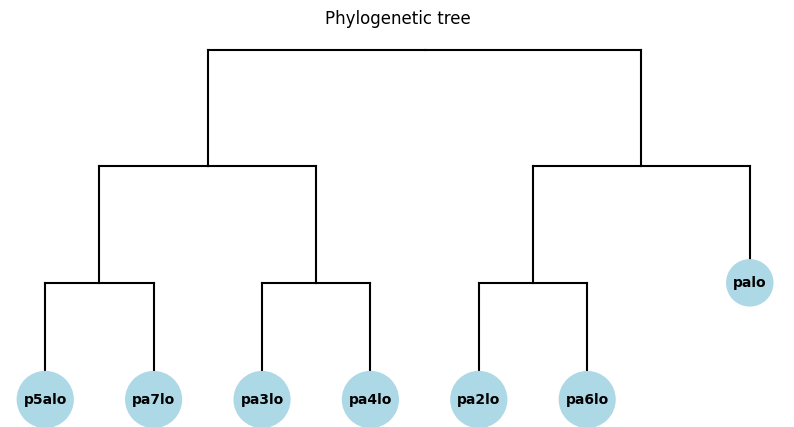

In [3]:
timer = Timer(0.0)
tree = bf_tree(matrix,timer=timer)
print('El arbol resultante es: \n\n')
tree.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')
names = ['palo','pa2lo','pa3lo','pa4lo','p5alo','pa6lo','pa7lo']
tree.display_tree(names=names)

YEAH. We get the same solution using a exact method. As a matter of fact, it may be faster, when removing the connections to D-Wave's Quantum Annealer. However, we can not test that...

<span style="font-weight: bold; color: #39ff14; font-size: larger;">SIKE</span>. We can do it although it could require a bit of tweaking of out functions. We only need the time used by the quantum annealer (that we can get), and the time to obtain and filter the results using brute force. That is the difference between methods, as everything else in the function works exactly the same. To solve this problem, we will use a new object (that is a encapsulated float) in both functions, that saves the time.

<span style="font-weight: bold; color: #FF0000; font-size: larger;">NOPE</span>. The QA is slower than a brute force method, at least for small values. That will probably change for bigger graphs.

New graph of 10 nodes:

<div style="text-align: center;">
    <img src="./images/randgraph_10.png" alt="Complete Graph" width="600px">
</div>

In [5]:
# matrix = nx.to_numpy_array(G)

matrix = np.array([[  0.,   4.,  70.,  88.,  30.,  36.,  23.,   5.,  72.,  36.],
       [  4.,   0.,  33.,  89.,   9.,  23.,  18.,   9.,  60.,  79.],
       [ 70.,  33.,   0.,  36.,  15., 100.,   7.,  14.,  10.,  18.],
       [ 88.,  89.,  36.,   0.,   6.,  35.,  69.,  96.,  67.,  15.],
       [ 30.,   9.,  15.,   6.,   0.,  66.,  54.,  45.,  77.,  49.],
       [ 36.,  23., 100.,  35.,  66.,   0.,  93.,   3.,  75.,  84.],
       [ 23.,  18.,   7.,  69.,  54.,  93.,   0.,   2.,  43.,   1.],
       [  5.,   9.,  14.,  96.,  45.,   3.,   2.,   0.,   6.,  86.],
       [ 72.,  60.,  10.,  67.,  77.,  75.,  43.,   6.,   0.,  95.],
       [ 36.,  79.,  18.,  15.,  49.,  84.,   1.,  86.,  95.,   0.]])

#### QA

The resulting tree is: 

└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── [5]
    │   │   │   └── [6]
    │   │   └── |
    │   │       ├── [4]
    │   │       └── [8]
    │   └── |
    │       ├── |
    │       │   ├── [0]
    │       │   └── [3]
    │       └── [2]
    └── |
        ├── |
        │   ├── [7]
        │   └── [9]
        └── [1]
The time used to compute the solutions is: 202.18652000000003ms


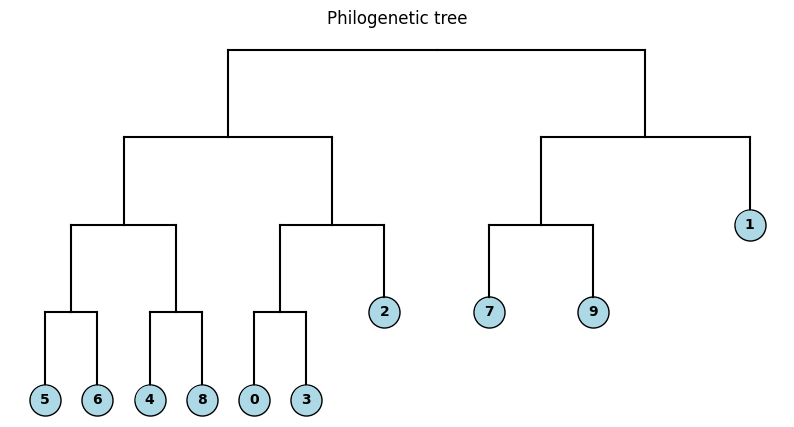

In [ ]:
# matrix = nx.to_numpy_array(G)
timer = Timer(0.0)
tree = phylo_tree(matrix,timer=timer)
print('The resulting tree is: \n')
tree.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')
tree.display_tree()

#### Brute Force

The resulting tree is: 

└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── [4]
    │   │   │   └── [8]
    │   │   └── |
    │   │       ├── [5]
    │   │       └── [6]
    │   └── |
    │       ├── [0]
    │       └── [2]
    └── |
        ├── |
        │   ├── [7]
        │   └── [9]
        └── |
            ├── [1]
            └── [3]
The time used to compute the solutions is: 62.548828125ms


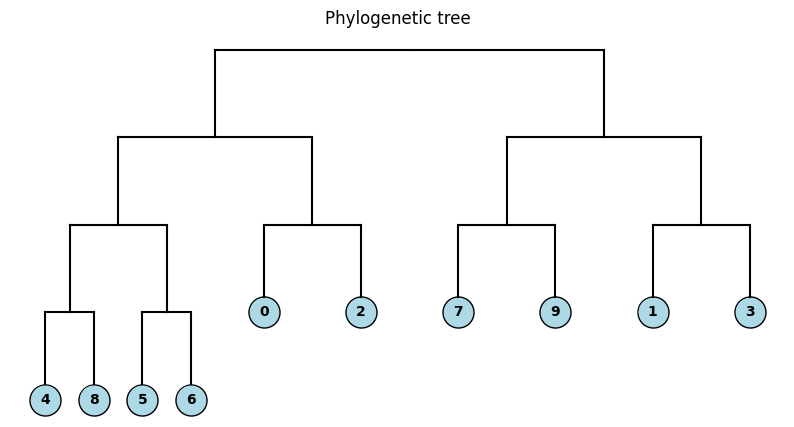

In [6]:
# matrix = nx.to_numpy_array(G)
timer = Timer(0.0)
tree = bf_tree(matrix,timer=timer)
print('The resulting tree is: \n')
tree.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')
tree.display_tree()

New graph of 13 nodes:

<div style="text-align: center;">
    <img src="./images/randgraph_13.png" alt="Complete Graph" width="600px">
</div>

In [7]:
# matrix = nx.to_numpy_array(G)
matrix = np.array([  [ 0.,  89.,  28.,  87.,  30.,  43.,  55.,   4.,  18.,  87.,   8., 67.,  23.],
                    [ 89.,   0.,  38.,  66.,  69.,  68.,  60.,  48.,  74.,   3.,  88., 33.,  92.],
                    [ 28.,  38.,   0.,  22.,  35.,  75.,  27.,  84.,  37.,  86.,  66., 92.,  35.],
                    [ 87.,  66.,  22.,   0.,  96.,  65.,  26.,  98.,  53.,   2.,  44., 38.,  95.],
                    [ 30.,  69.,  35.,  96.,   0.,  93.,  32.,  62.,  59.,  44.,  29., 69.,  41.],
                    [ 43.,  68.,  75.,  65.,  93.,   0.,  20.,  28.,  46.,  91.,  12., 86.,  34.],
                    [ 55.,  60.,  27.,  26.,  32.,  20.,   0.,  71.,   4.,  60.,  72., 46.,  37.],
                    [  4.,  48.,  84.,  98.,  62.,  28.,  71.,   0.,  65.,  61.,  29., 14.,   4.],
                    [ 18.,  74.,  37.,  53.,  59.,  46.,   4.,  65.,   0.,  73.,  14., 5.,  21.],
                    [ 87.,   3.,  86.,   2.,  44.,  91.,  60.,  61.,  73.,   0.,  36., 100., 100.],
                    [  8.,  88.,  66.,  44.,  29.,  12.,  72.,  29.,  14.,  36.,   0., 77.,  88.],
                    [ 67.,  33.,  92.,  38.,  69.,  86.,  46.,  14.,   5., 100.,  77., 0.,  49.],
                    [ 23.,  92.,  35.,  95.,  41.,  34.,  37.,   4.,  21., 100.,  88., 49.,   0.]])

#### Brute Force

The resulting tree is: 

└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── |
    │   │   │   │   ├── [9]
    │   │   │   │   └── [11]
    │   │   │   └── [2]
    │   │   └── [5]
    │   └── |
    │       ├── |
    │       │   ├── [7]
    │       │   └── [8]
    │       └── [4]
    └── |
        ├── |
        │   ├── |
        │   │   ├── |
        │   │   │   ├── [1]
        │   │   │   └── [12]
        │   │   └── [10]
        │   └── [3]
        └── |
            ├── [0]
            └── [6]
The time used to compute the solutions is: 526.3291015625ms


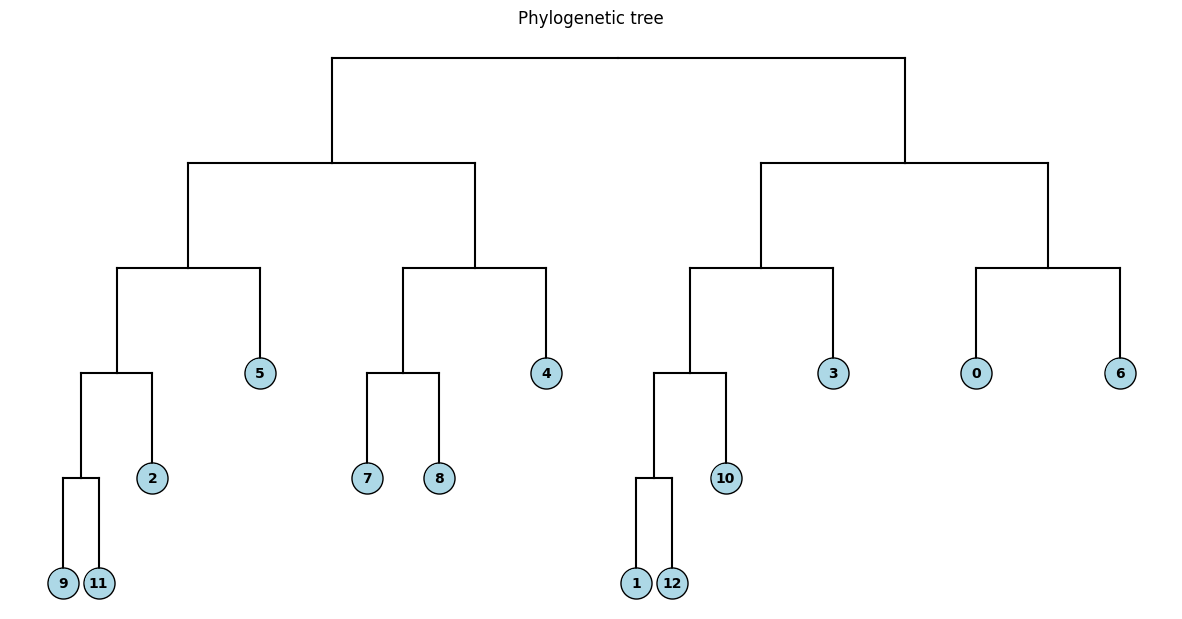

In [8]:
timer1 = Timer(0.0)
treebf = bf_tree(matrix,timer=timer1)
print('The resulting tree is: \n')
treebf.print_tree()
print(f'The time used to compute the solutions is: {timer1}ms')
treebf.display_tree(tree_size=1.5)

The resulting tree is: 

└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── |
    │   │   │   │   ├── [9]
    │   │   │   │   └── [11]
    │   │   │   └── [2]
    │   │   └── [5]
    │   └── |
    │       ├── |
    │       │   ├── [7]
    │       │   └── [8]
    │       └── [4]
    └── |
        ├── |
        │   ├── |
        │   │   ├── |
        │   │   │   ├── [1]
        │   │   │   └── [12]
        │   │   └── [10]
        │   └── [3]
        └── |
            ├── [0]
            └── [6]
The time used to compute the solutions is: 0.0ms


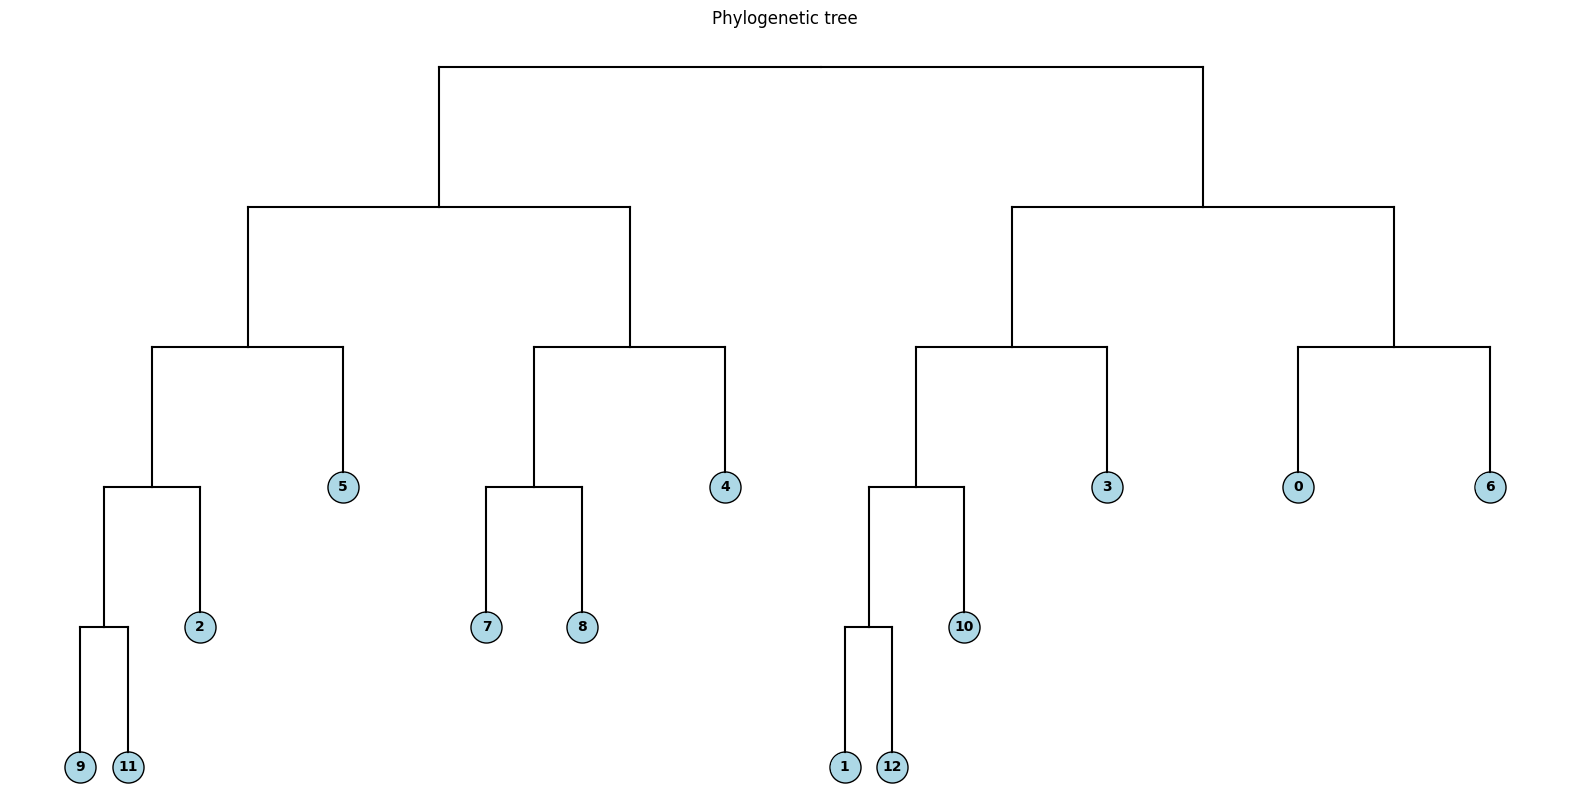

In [ ]:
timer2 = Timer(0.0)
treeqa = phylo_tree(matrix,timer=timer2)
print('The resulting tree is: \n')
treeqa.print_tree()
print(f'The time used to compute the solutions is: {timer2}ms')
treeqa.display_tree(tree_size=2)

In [ ]:
acc = treecmp(treebf.to_newick(),treeqa.to_newick())

print(f'The accuracy of the tree is: {acc}')
print(f'The speedup of the QA over BF is : {timer1.value/timer2.value}')

The accuracy of the tree is: 100.0


ZeroDivisionError: float division by zero

## Tests using real sequences

We will start using real sequences from different databases. Firstly, we need a function to transform fasta files into matrices.

In [12]:
# Load sequences from FASTA file
def load_sequences(fasta_file,format='fasta'):
    sequences = []
    labels = []
    for record in SeqIO.parse(fasta_file, format):
        sequences.append(str(record.seq))
        labels.append(str(record.id))
    return sequences,labels

# Compute pairwise alignment scores using BLOSUM62 and normalizing as the paper do
def compute_distance_matrix(sequences):
    aligner = Align.PairwiseAligner()
    blosum62 = substitution_matrices.load("BLOSUM62")
    aligner.mode='global'
    aligner.substitution_matrix = blosum62
    aligner.open_gap_score = -10  # Gap opening penalty
    aligner.extend_gap_score = -0.5  # Gap extension penalty
    
    n = len(sequences)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                distance_matrix[i, j] = 0  # Distance with itself is 0                
            else:
                sequences[i] = sequences[i].replace('-',"")
                sequences[j] = sequences[j].replace('-',"")
                score = aligner.score(sequences[i], sequences[j])
                biti = aligner.score(sequences[i], sequences[i])
                bitj = aligner.score(sequences[j], sequences[j])
                # Convert score to a distance (example: max_score - score)
                distance_matrix[i, j] = 100*score/np.mean([biti,bitj])  # Negative alignment score for distance

    return distance_matrix

# Save the distance matrix as a CSV or visualize it
def save_distance_matrix(matrix, labels, output_file):
    df = pd.DataFrame(matrix, index=labels, columns=labels)
    df.to_csv(output_file)
    print(f"Distance matrix saved to {output_file}")
    
def transform_distance(matrix):
    rows = matrix.shape[0]
    dmatrix = []
    names = []
    for i in range(rows):
        names.append(str(i))
        aux = []
        for j in range(i+1):
            aux.append(100 - matrix[i,j])
        dmatrix.append(aux)
    
    return dmatrix,names

First, let's start with a toy example, where we compare the genomes from:
- Chimp
- Human
- Seal
- Whale

In [37]:
# Main execution
fasta_file = "toy.fasta" 
# output_file = "distance_matrix.csv"

sequences,labels = load_sequences(fasta_file)
distance_matrix = compute_distance_matrix(sequences)
print(distance_matrix)
# save_distance_matrix(distance_matrix, labels, output_file)

[[ 0.         66.08695652 46.4        65.54621849]
 [66.08695652  0.         24.56140351 44.44444444]
 [46.4        24.56140351  0.         77.96610169]
 [65.54621849 44.44444444 77.96610169  0.        ]]


The resulting tree is: 

└── |
    ├── |
    │   ├── [0]
    │   └── [1]
    └── |
        ├── [2]
        └── [3]
The time used to compute the solutions is: 18.1611328125ms


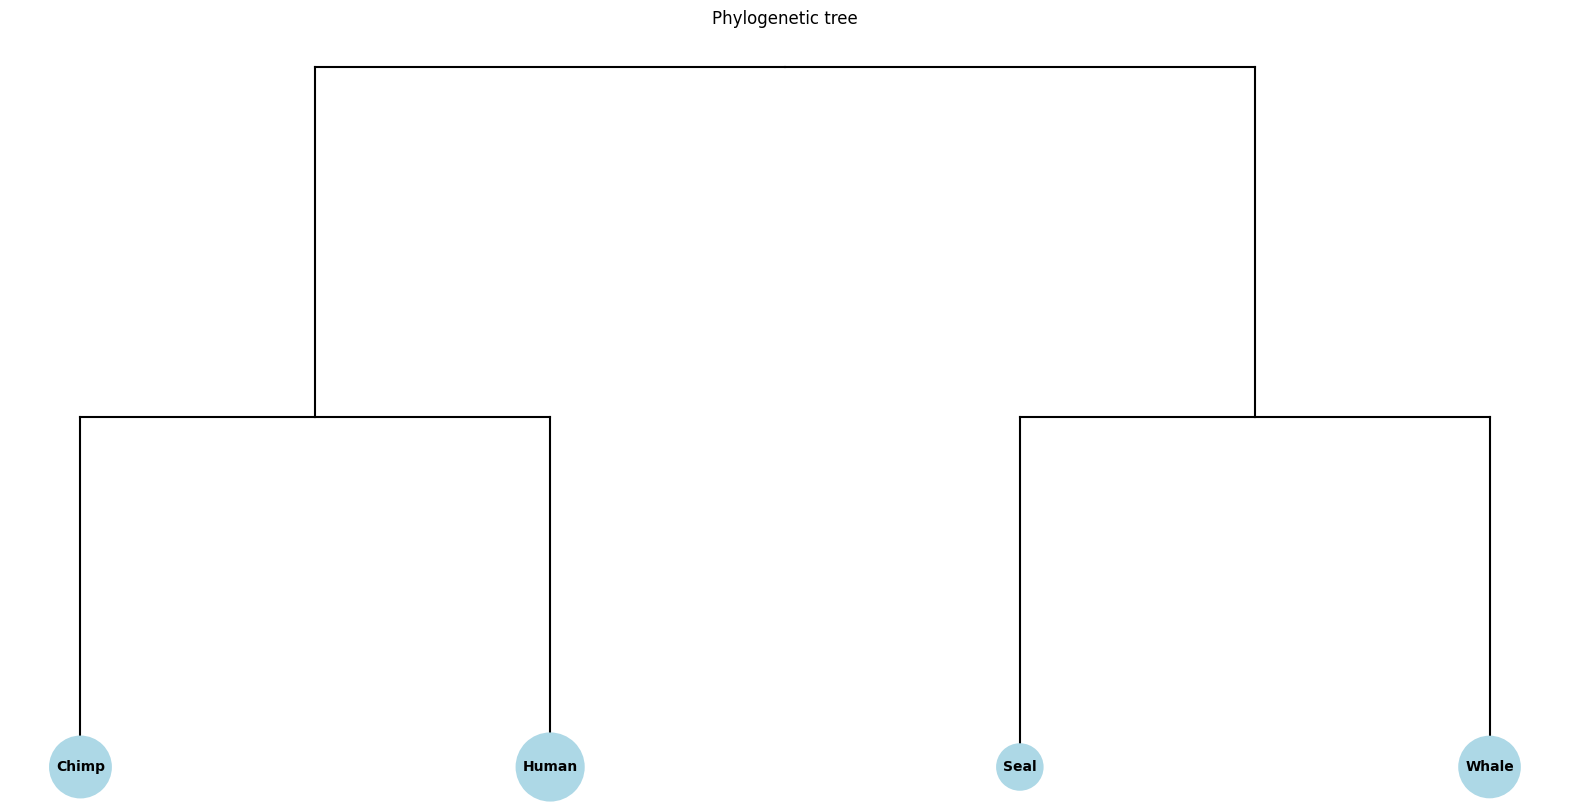

In [13]:
timer = Timer(0.0)
tree = bf_tree(distance_matrix,timer=timer)
print('The resulting tree is: \n')
tree.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')
names = ['Chimp','Human','Seal','Whale']
pos, par_pos = calculate_positions(tree)
display_tree(pos, par_pos,tree_size=2,names=names)

In [38]:
# Main execution
fasta_file = "big_al.phy" 
# output_file = "distance_matrix.csv"+

sequences,labels = load_sequences(fasta_file,format='phylip')
distance_matrix = compute_distance_matrix(sequences)
print(labels)
print(distance_matrix)
# save_distance_matrix(distance_matrix, labels, output_file)


['t0', 't1', 't2', 't3', 't4']
[[ 0.         41.8715626  84.2537654  26.71685828 26.9364044 ]
 [41.8715626   0.         42.97748259 37.33525307 37.10608078]
 [84.2537654  42.97748259  0.         27.29589237 27.7516847 ]
 [26.71685828 37.33525307 27.29589237  0.         93.34568473]
 [26.9364044  37.10608078 27.7516847  93.34568473  0.        ]]


The resulting tree is: 

└── |
    ├── |
    │   ├── |
    │   │   ├── [0]
    │   │   └── [2]
    │   └── [1]
    └── |
        ├── [3]
        └── [4]
The time used to compute the solutions is: 2.10205078125ms


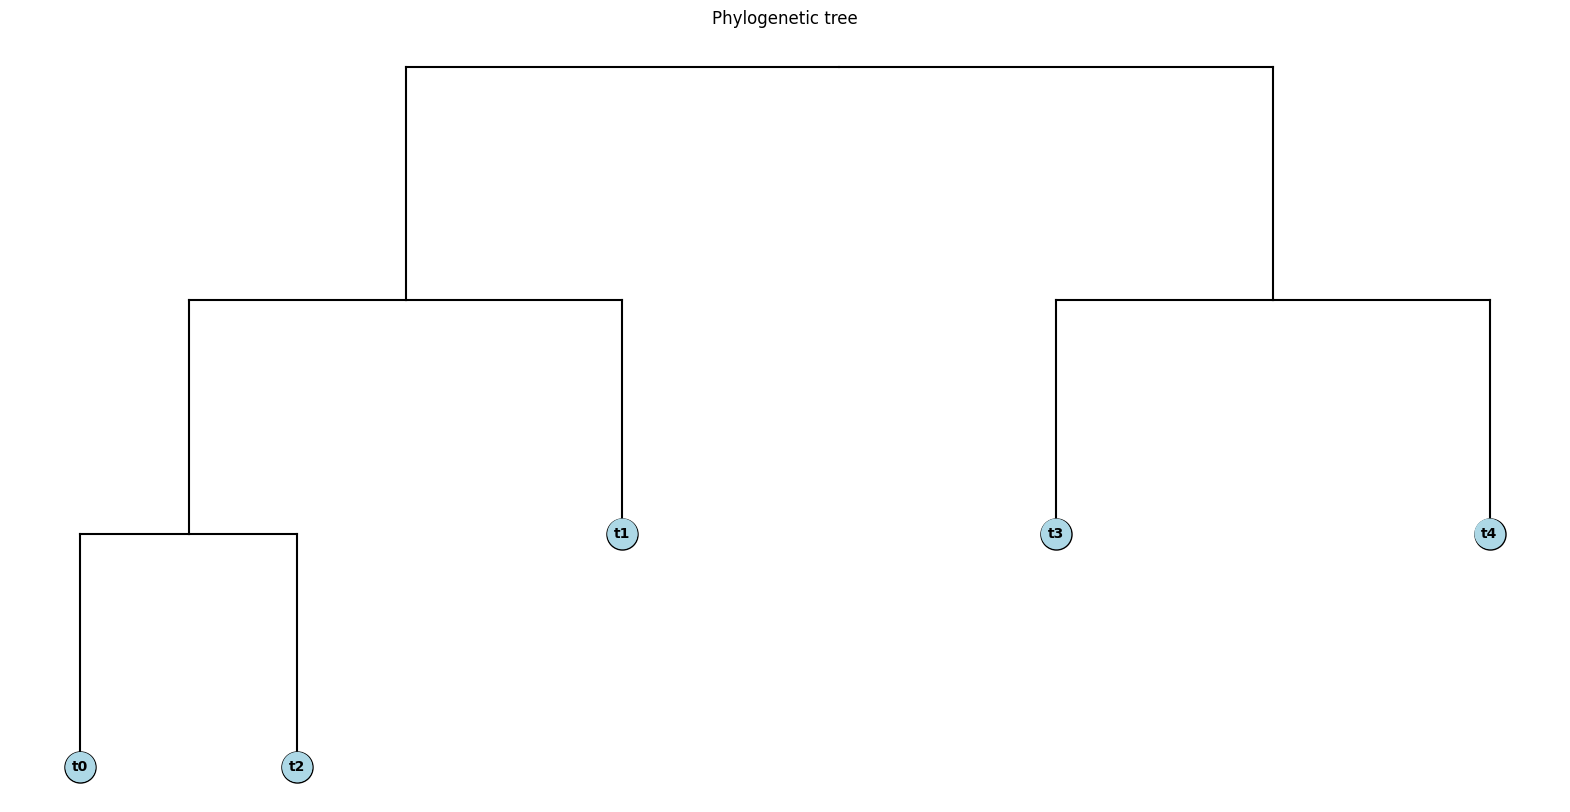

In [39]:
timer = Timer(0.0)
tree = bf_tree(distance_matrix,timer=timer)
print('The resulting tree is: \n')
tree.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')
pos, par_pos = calculate_positions(tree)
display_tree(pos, par_pos,tree_size=2,names=labels)

## Test using big alignments

### 20 protein sequences

In [77]:
file = "alignments/COG6.sim.p" 
# output_file = "distance_matrix.csv"

sequences,labels = load_sequences(file,format='phylip')
distance_matrix = compute_distance_matrix(sequences)
print(labels)
# print(distance_matrix)

['N1', 'N139', 'N214', 'N7', 'N22', 'N197', 'N237', 'N97', 'N134', 'N124', 'N38', 'N153', 'N116', 'N51', 'N101', 'N48', 'N43', 'N186', 'N121']


In [108]:
timer = Timer(0.0)
tree = bf_tree(distance_matrix,timer=timer)
print('The resulting tree is: \n')
tree.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')
tree.create_newick_file('COG6_bf')

The resulting tree is: 

└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── |
    │   │   │   │   ├── |
    │   │   │   │   │   ├── |
    │   │   │   │   │   │   ├── [17]
    │   │   │   │   │   │   └── [18]
    │   │   │   │   │   └── |
    │   │   │   │   │       ├── [4]
    │   │   │   │   │       └── [16]
    │   │   │   │   └── |
    │   │   │   │       ├── [5]
    │   │   │   │       └── [15]
    │   │   │   └── |
    │   │   │       ├── |
    │   │   │       │   ├── |
    │   │   │       │   │   ├── [10]
    │   │   │       │   │   └── [11]
    │   │   │       │   └── [9]
    │   │   │       └── |
    │   │   │           ├── [3]
    │   │   │           └── [12]
    │   │   └── |
    │   │       ├── [7]
    │   │       └── [8]
    │   └── |
    │       ├── [0]
    │       └── [1]
    └── |
        ├── |
        │   ├── |
        │   │   ├── [13]
        │   │   └── [14]
        │   └── [2]
        └── [6]
The time used to compute the solutions is: 51342.777832031

In [119]:
timer = Timer(0.0)
tree_qa = phylo_tree(distance_matrix,timer=timer)
print('The resulting tree is: \n')
tree_qa.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')
tree_qa.create_newick_file('COG6_qa')

The resulting tree is: 

└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── |
    │   │   │   │   ├── |
    │   │   │   │   │   ├── |
    │   │   │   │   │   │   ├── [10]
    │   │   │   │   │   │   └── [11]
    │   │   │   │   │   └── [9]
    │   │   │   │   └── |
    │   │   │   │       ├── |
    │   │   │   │       │   ├── [4]
    │   │   │   │       │   └── [12]
    │   │   │   │       └── [3]
    │   │   │   └── |
    │   │   │       ├── |
    │   │   │       │   ├── |
    │   │   │       │   │   ├── [17]
    │   │   │       │   │   └── [18]
    │   │   │       │   └── [16]
    │   │   │       └── |
    │   │   │           ├── [5]
    │   │   │           └── [15]
    │   │   └── |
    │   │       ├── [7]
    │   │       └── [8]
    │   └── |
    │       ├── [1]
    │       └── [2]
    └── |
        ├── |
        │   ├── |
        │   │   ├── [13]
        │   │   └── [14]
        │   └── [6]
        └── [0]
The time used to compute the solutions is: 883.73048ms


## We have a problem

The brute force solver from D-Wave used in `bf_tree` doesn't allow more than 64 elements (for obvious reasons). Similarly, the Quantum Annealer has 512 qubits, but this computation will probably exceed the maximum time availiable:

$$T_{max} = \sum_{n=1}^{125}n\cdot\mu_{time}= \frac{125\cdot126}{2}\cdot\mu_{time}, \quad \mu_{time}=16.0ms$$

Computing this time, we get that $T_{max}=126000ms=126s>60s=T_{total}$. It's true that this is the worst case, however, it is theoretically posible that this occurs, meaning the computation would be incomplete. We can calculate a theoretical maximum number of nodes, however, we will use $\mu_{time}=17ms$ to be sure it is overestimated.

$$60000 = \frac{x\cdot(x+1)}{2}\cdot\mu_{time}\implies x\cdot (x+1) = \frac{120000}{\mu_{time}}\implies x^2 + x - 7058.82 = 0 \implies x=83.5, \text{when removing the negative solution.} $$

This means that we can completely assure that we can solve a problem containing 83 sequences using the trial time from D-Wave.

We can instead compare a subset of the population using the Phylogenetic tree generator from `BioPython`

In [ ]:
dmatrix,names = transform_distance(distance_matrix)
dmatrix = DistanceMatrix(names=names,matrix=dmatrix)
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dmatrix)

# Visualize the tree
# Phylo.draw_ascii(tree)

# Remove branch lengths

for clade in tree.find_clades():
    clade.branch_length = None

# Save the tree
Phylo.write(tree, "COG6_bp.nwk", "newick")

1

In [ ]:
with open('COG6_bf.tree','r') as file:
    bf_tree = file.read()
    
with open('COG6_qa.tree','r') as file:
    qa_tree = file.read()

with open('COG6_bp.nwk','r') as file:
    biotree = file.read()

biotree = biotree.replace(':0.00000','')
biotree = re.sub(r"Inner[0-9]*",'',biotree)

dist = treecmp(bf_tree,biotree)

print(f'The Robinson-Foulds distance bewteen the Ncut with brute force tree and the Neighbor-Joining tree is {dist} ')

dist = treecmp(qa_tree,biotree)

print(f'The Robinson-Foulds distance bewteen the Ncut with QA tree and the Neighbor-Joining tree is {dist} ')

dist = treecmp(qa_tree,bf_tree)

print(f'The Robinson-Foulds distance bewteen the Ncut with QA tree and the Ncut with brute force tree is {dist} ')

The Robinson-Foulds distance bewteen the Ncut with brute force tree and the Neighbor-Joining tree is 56.25 
The Robinson-Foulds distance bewteen the Ncut with QA tree and the Neighbor-Joining tree is 43.75 
The Robinson-Foulds distance bewteen the Ncut with QA tree and the Ncut with brute force tree is 50.0 


## Observation 1

While running the QA, we get that in a size $N$ problem, it approximately takes the resolution of $N$ different problems, so we can increase the size of the proteins that we are using. We are going to try size 50. The file containing 50 protein sequences is: "/alignments/COG8.sim.p"

### 50 Proteins

In [20]:
file = "alignments/COG8.sim.p" 
# output_file = "distance_matrix.csv"

sequences,labels = load_sequences(file,format='phylip')
distance_matrix = compute_distance_matrix(sequences)
print(labels)
# print(distance_matrix)

['N1', 'N119', 'N6', 'N79', 'N51', 'N225', 'N138', 'N118', 'N218', 'N171', 'N124', 'N238', 'N242', 'N63', 'N183', 'N129', 'N219', 'N49', 'N38', 'N165', 'N14', 'N153', 'N181', 'N179', 'N159', 'N84', 'N135', 'N54', 'N58', 'N234', 'N7', 'N52', 'N163', 'N204', 'N186', 'N61', 'N146', 'N151', 'N241', 'N193', 'N237', 'N59', 'N208', 'N199', 'N13', 'N215', 'N184', 'N41', 'N245', 'N142']


In [ ]:
timer = Timer(0.0)
tree_qa = phylo_tree(distance_matrix,timer=timer)
# print('The resulting tree is: \n')
# tree_qa.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')
tree_qa.create_newick_file('./trees/COG8_qa')

In [23]:
dmatrix,names = transform_distance(distance_matrix)
dmatrix = DistanceMatrix(names=names,matrix=dmatrix)
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dmatrix)

# Visualize the tree
# Phylo.draw_ascii(tree)

# Remove branch lengths

for clade in tree.find_clades():
    clade.branch_length = None

# Save the tree
Phylo.write(tree, "./trees/COG8_bp.nwk", "newick")

1

In [24]:
with open('./trees/COG8_qa.nwk','r') as file:
    qa_tree = file.read()

with open('./trees/COG8_bp.nwk','r') as file:
    biotree = file.read()

biotree = biotree.replace(':0.00000','')
biotree = re.sub(r"Inner[0-9]*",'',biotree)

dist = treecmp(qa_tree,biotree)

print(f'The Robinson-Foulds distance bewteen the Ncut with QA tree and the Neighbor-Joining tree is {dist} ')

The Robinson-Foulds distance bewteen the Ncut with QA tree and the Neighbor-Joining tree is 8.51 


In [2]:
def random_matrix(size):
    
    random_matrix = np.random.uniform(0, 100 + 1, (size, size))
    
    matrix = (random_matrix + random_matrix.T) / 2
    np.fill_diagonal(matrix, 0)
    return matrix

## Paralelizacion

Se puede hacer de varias maneras:

1. **Paralelización de ramas**: Esto es a la que el arbol se corta, se vuelve a llamar a la funcion por cada rama. Como las ramas son independientes, pueden llamarse a la vez.
2. **Paralelización de ejecuciones**: Cada llamada al QA para cada tamaño de $c$ es independiente de la anterior, por lo que se puede paralelizar. Sigues dependiendo de que los trabajos entren al QA, pero al añadir todas la peticiones a la vez, reduces tiempo de espera.


Mañana ejecutar varios arboles de entre 20/50

Just as a **"fun fact"** of sorts, we can calculate the maximum and minimum subproblems of a $N$ size tree that need to be solved by the QA:

As disclosed before, the maximum number of problems follows a simple series so:
$$Max_{iter}=\frac{N(N+1)}{2}.$$

The minimum can be interpreted as a binary tree of children, where the last step would be 2 children. After some calculations, we have that:

$$Min_{iter}=\left\lceil\frac{N}{2}\log_2{\frac{N}{2}}\right\rceil.$$

Observing the number of problems, we can deduce that the evolutions could be defined by:

$$Max_{iter} \sim \mathcal{O}(N^2),\quad Min_{iter}\sim \mathcal{O}(N\log N).$$

This essentially means that the feasible region of the number of problems will be very variable, and a good mean could be the lineal curve:

$$\mu:t \in\mathbb{R}\rightarrow\mathbb{R}\implies \mu(t)=ct^2, \quad c\in\mathbb{R}.$$

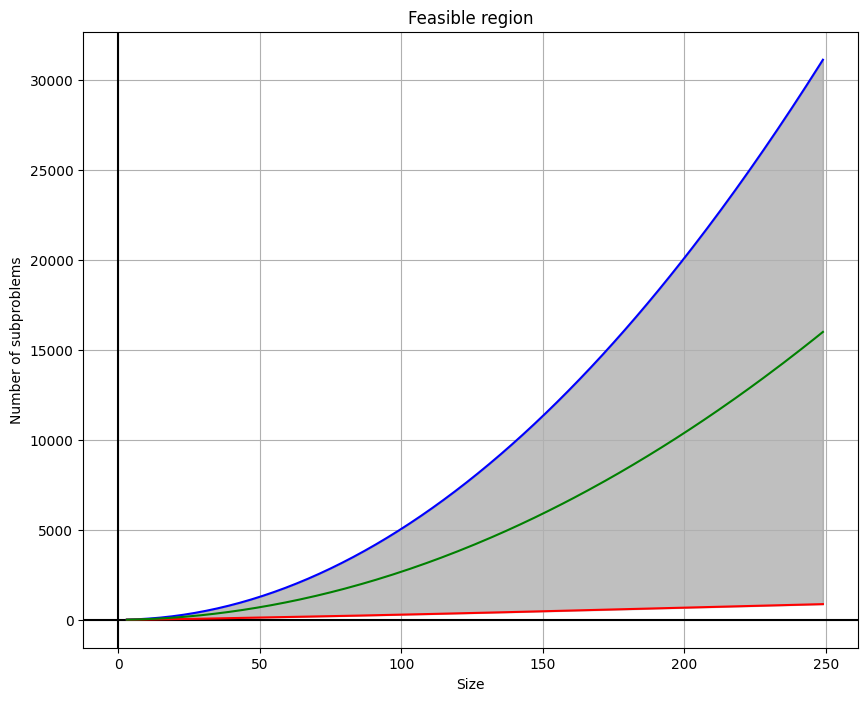

In [13]:
def max_iter(x):
    iter = x*(x+1)/2
    return iter

def min_iter(x):
    iter = np.ceil((x/2)*np.log2(x/2))
    return iter

x = np.arange(3,250)
y1 = max_iter(x)
y2 = min_iter(x)


mean = (y1+y2)/2

fig, ax = plt.subplots(figsize=(10,8))

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.plot(x, y1, linestyle='-', color='blue')
plt.plot(x, y2, linestyle='-', color='red')
plt.plot(x, mean, linestyle='-', color='green')
plt.fill_between(x, y1, y2, color='gray', alpha=0.5, label='Feasible Region')
plt.xlabel('Size')
plt.ylabel('Number of subproblems')
plt.title('Feasible region')
plt.grid(True)
plt.show()

The parameter is: [0.25952897]. The covariance is: [[1.38873998e-08]]


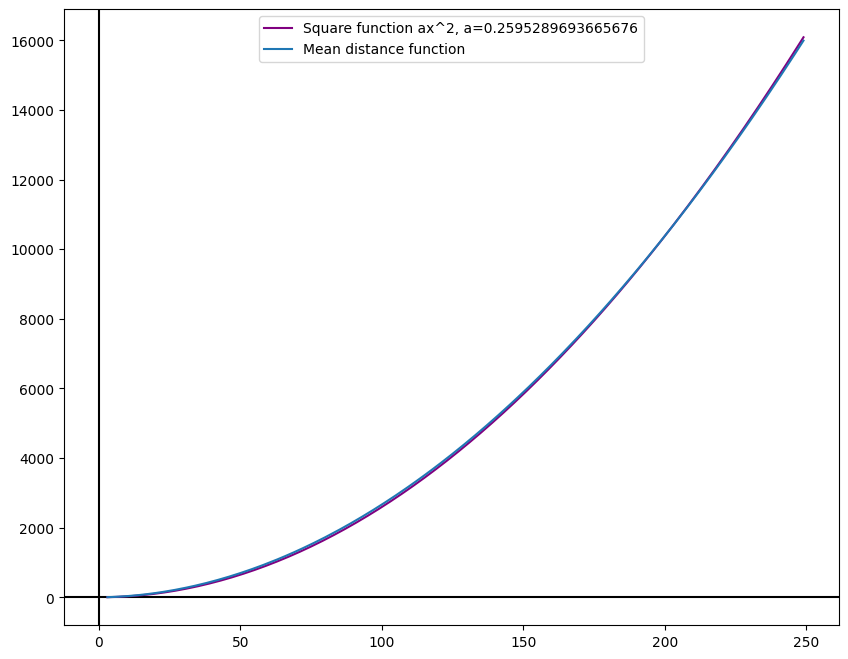

In [15]:
from scipy.optimize import curve_fit

def func(x, a):
    return a * x**2

popt,pcov = curve_fit(func,x,mean,p0=[1.0])

print(f'The parameter is: {popt}. The covariance is: {pcov}')

fig, ax = plt.subplots(figsize=(10,8))

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.plot(x, func(x, *popt), label='Square function ax^2, a='+str(*popt), color='purple')
plt.plot(x,mean,label="Mean distance function")
plt.legend(loc="upper center")
plt.show()

Using this mean as a predictor, we can obtain the approximate number of subproblems for each size. For example, using the last tree that we created that has 50 nodes.

In [102]:
print(f'Real number of subproblems: {255-102}')
print(f'Prediction of subproblems: {func(50,*popt)}')

Real number of subproblems: 153
Prediction of subproblems: 648.822423416419


As we can see, the real number of subproblems is waaaaay lower than our estimate, which is good, really good. Moreover, we can see that the real number is skewed towards the lower limit. What this means, is that the $N_{cut}$ approach tends to create balanced trees.

**However**, we can use this curve as a sort of "experimental maximum" so we can create a better estimate where the QA wouldn't allow the execution:

$$60000 = 0.259\cdot x^2 \cdot\mu_{time}\implies x = \sqrt{\frac{60000}{0.259\cdot\mu_{time}}}=116.74.$$

So we can guarantee that at least we can create and solve problems of 116 nodes.

To better fit the skew of the model, we will try a problem with 75 nodes.

### 75 sequences

In [3]:
file = "alignments/COG9.sim._sliced.p" 
# output_file = "distance_matrix.csv"

sequences,labels = load_sequences(file,format='phylip')
distance_matrix = compute_distance_matrix(sequences)
print(labels)
# print(distance_matrix)

['N1', 'N98', 'N49', 'N192', 'N26', 'N105', 'N147', 'N159', 'N96', 'N194', 'N55', 'N218', 'N157', 'N12', 'N124', 'N191', 'N186', 'N5', 'N133', 'N221', 'N32', 'N82', 'N72', 'N250', 'N121', 'N201', 'N111', 'N233', 'N35', 'N39', 'N90', 'N137', 'N249', 'N114', 'N189', 'N89', 'N76', 'N100', 'N156', 'N240', 'N116', 'N24', 'N195', 'N162', 'N169', 'N163', 'N168', 'N46', 'N224', 'N206', 'N23', 'N173', 'N33', 'N128', 'N101', 'N95', 'N44', 'N185', 'N8', 'N167', 'N136', 'N230', 'N92', 'N161', 'N158', 'N75', 'N50', 'N242', 'N63', 'N73', 'N14', 'N70', 'N235', 'N130', 'N48']


In [8]:
timer = Timer(0.0)
tree_qa = phylo_tree(distance_matrix,timer=timer)
# print('The resulting tree is: \n')
# tree_qa.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')
tree_qa.create_newick_file('./trees/COG9_qa')

The time used to compute the solutions is: 5138.5038799999975ms


In [28]:
# tree_qa.display_tree(tree_size=25,names=labels)

In [7]:
dmatrix,names = transform_distance(distance_matrix)
dmatrix = DistanceMatrix(names=names,matrix=dmatrix)
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dmatrix)

# Visualize the tree
# Phylo.draw_ascii(tree)

# Remove branch lengths

for clade in tree.find_clades():
    clade.branch_length = None

# Save the tree
Phylo.write(tree, "./trees/COG9_bp.nwk", "newick")

1

In [ ]:
with open('./trees/COG9_qa_75.nwk','r') as file:
    qa_tree = file.read()

with open('./trees/COG9_bp_75.nwk','r') as file:
    biotree = file.read()

biotree = biotree.replace(':0.00000','')
biotree = re.sub(r"Inner[0-9]*",'',biotree)

dist = treecmp(qa_tree,biotree)

print(f'The Robinson-Foulds distance bewteen the Ncut with QA tree and the Neighbor-Joining tree is \033[1m{dist}\033[22m.')

The Robinson-Foulds distance bewteen the Ncut with QA tree and the Neighbor-Joining tree is 11.11.


Btw, using 75 nodes, the number of subproblems was $257$, where the mean curve $\mu(75)\approx1459$. This is  only $17.61\%$ of the function. Also, the minimum iterations are $197$. We can input some known number of subproblems (5, 10, 15, 20, 25, 50, 75) and get an estimate curve.

In [15]:
file = "alignments/COG9.sim.p" 
# output_file = "distance_matrix.csv"

slice_alignment(file,25)

sequences,labels = load_sequences("alignments/COG9.sim._sliced_25.p",format='phylip')
distance_matrix = compute_distance_matrix(sequences)
print(labels)

timer = Timer(0.0)
tree_qa = phylo_tree(distance_matrix,timer=timer)
# print('The resulting tree is: \n')
# tree_qa.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')

['N1', 'N98', 'N49', 'N192', 'N26', 'N105', 'N147', 'N159', 'N96', 'N194', 'N55', 'N218', 'N157', 'N12', 'N124', 'N191', 'N186', 'N5', 'N133', 'N221', 'N32', 'N82', 'N72', 'N250', 'N121']
The time used to compute the solutions is: 2034.5709200000006ms


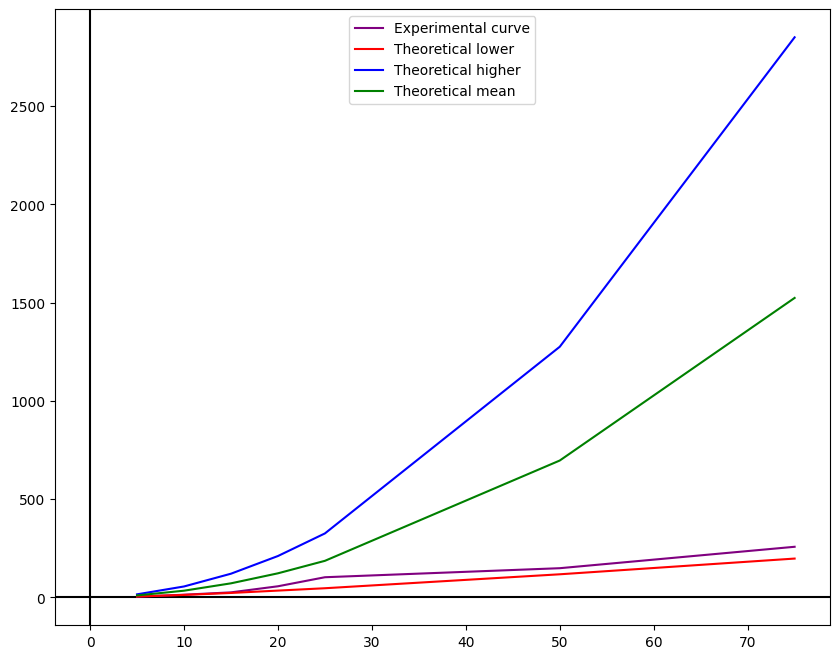

In [27]:
x = [5,10,15,20,25,50,75]
y = [3,13,25,56,102,148,257]

y_low = min_iter(np.array(x))
y_high = max_iter(np.array(x))
mean = (y_low+y_high)/2
fig, ax = plt.subplots(figsize=(10,8))
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.plot(x, y,color='purple',label='Experimental curve')
plt.plot(x,y_low,color='red',label='Theoretical lower')
plt.plot(x,y_high,color='blue',label='Theoretical higher')
plt.plot(x,mean,color='green',label='Theoretical mean')
plt.legend()
plt.show()

The parameter is: [ 0.35201913 10.81542551]. The covariance is: [[ 6.43331274e-02 -1.26448629e+01]
 [-1.26448629e+01  2.49928871e+03]]


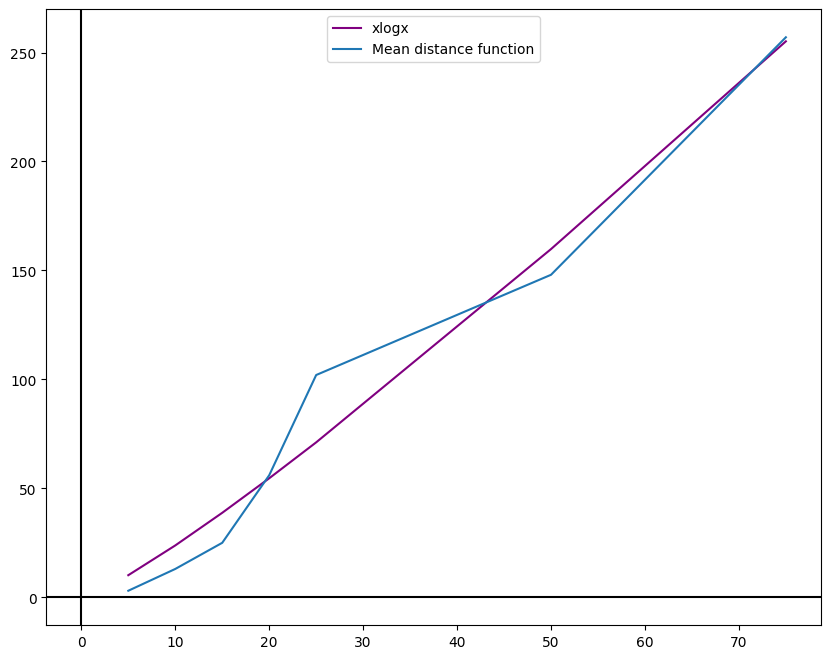

The expected number of subproblems for a graph of 100 nodes is 354.79566945579654


In [26]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return x* a * np.log2(x*b)

popt,pcov = curve_fit(func,x,y,p0=[1.0,1.0])

print(f'The parameter is: {popt}. The covariance is: {pcov}')

fig, ax = plt.subplots(figsize=(10,8))

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.plot(x, func(np.array(x), *popt), label='xlogx', color='purple')
plt.plot(x,y,label="Mean distance function")
plt.legend(loc="upper center")
plt.show()
print(f'The expected number of subproblems for a graph of 100 nodes is {func(100,*popt)}')

We can use the function with this parameters to get the approximation that we would need 354 subproblems for a 100 node problem. Let's try it:

### 100 sequences

In [29]:
slice_alignment('alignments/COG9.sim.p',100)

In [30]:
file = "alignments/COG9.sim._sliced_100.p" 
# output_file = "distance_matrix.csv"

sequences,labels = load_sequences(file,format='phylip')
distance_matrix = compute_distance_matrix(sequences)
print(labels)
# print(distance_matrix)

['N1', 'N98', 'N49', 'N192', 'N26', 'N105', 'N147', 'N159', 'N96', 'N194', 'N55', 'N218', 'N157', 'N12', 'N124', 'N191', 'N186', 'N5', 'N133', 'N221', 'N32', 'N82', 'N72', 'N250', 'N121', 'N201', 'N111', 'N233', 'N35', 'N39', 'N90', 'N137', 'N249', 'N114', 'N189', 'N89', 'N76', 'N100', 'N156', 'N240', 'N116', 'N24', 'N195', 'N162', 'N169', 'N163', 'N168', 'N46', 'N224', 'N206', 'N23', 'N173', 'N33', 'N128', 'N101', 'N95', 'N44', 'N185', 'N8', 'N167', 'N136', 'N230', 'N92', 'N161', 'N158', 'N75', 'N50', 'N242', 'N63', 'N73', 'N14', 'N70', 'N235', 'N130', 'N48', 'N236', 'N80', 'N107', 'N208', 'N213', 'N228', 'N97', 'N231', 'N212', 'N113', 'N77', 'N3', 'N164', 'N109', 'N91', 'N184', 'N58', 'N153', 'N225', 'N204', 'N19', 'N193', 'N30', 'N170', 'N215']


In [34]:
timer = Timer(0.0)
tree_qa = phylo_tree(distance_matrix,timer=timer)
# print('The resulting tree is: \n')
# tree_qa.print_tree()
print(f'The time used to compute the solutions is: {timer}ms')
tree_qa.create_newick_file('./trees/COG9_qa_100')

The time used to compute the solutions is: 7893.5261999999975ms


In [33]:
dmatrix,names = transform_distance(distance_matrix)
dmatrix = DistanceMatrix(names=names,matrix=dmatrix)
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dmatrix)

# Visualize the tree
# Phylo.draw_ascii(tree)

# Remove branch lengths

for clade in tree.find_clades():
    clade.branch_length = None

# Save the tree
Phylo.write(tree, "./trees/COG9_bp_100.nwk", "newick")

1

In [36]:
with open('./trees/COG9_qa_100.nwk','r') as file:
    qa_tree = file.read()

with open('./trees/COG9_bp_100.nwk','r') as file:
    biotree = file.read()

biotree = biotree.replace(':0.00000','')
biotree = re.sub(r"Inner[0-9]*",'',biotree)

dist = treecmp(qa_tree,biotree)

print(f'The Robinson-Foulds distance bewteen the Ncut with QA tree and the Neighbor-Joining tree is \033[1m{dist}\033[22m')

The Robinson-Foulds distance bewteen the Ncut with QA tree and the Neighbor-Joining tree is 6.19


The number of subproblems was $391$. That is pretty similar to the estimate of $354$. This means that the curve:

$$\mu(x)=0.35x\cdot \log_2{10.82x},$$

is a good approximation of the number of subproblems